In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
output_path = project_root / "arc2_partial_max.parquet"

In [3]:
from llm_python.datasets.superking import load_superking

superking_df = load_superking()

Bucket: gs://trelis-arc/datasets/superkingplus/
Found 1 parquet files in datasets/superkingplus/
Loading superking dataset...


In [4]:
# Keep only refined examples.
from llm_python.datasets.query import filter_soar_df


df = superking_df.copy()
df = filter_soar_df(
    df,
    exclude_subset="arc-prize-2025/evaluation",
    any_train_correct=True,
    exclude_transductive=True
)


In [5]:
df = df[df["refined_from_id"].isna()]
df.drop(columns=["reasoning"], inplace=True)

In [6]:
# Deduplicate df by task_id and code
initial_len = len(df)
df = (
    df.drop_duplicates(subset=["task_id", "code"], keep="first")
      .reset_index(drop=True)
)
print(f"Deduplicated rows: {len(df) } (removed {initial_len - len(df)})")

Deduplicated rows: 359620 (removed 85738)


In [ ]:
import concurrent.futures
import numpy as np
import pandas as pd
from tqdm import tqdm
from llm_python.datasets.validation import validate_soar_row_correctness
from llm_python.utils.arc_tester import ArcTester

arc_tester = ArcTester()

def process_row(row_tuple):
    _, row = row_tuple
    row_dict = row.to_dict()
    
    correctness_result = validate_soar_row_correctness(row_dict, arc_tester)
    
    stats = {"fixed": 0, "correct": 0, "invalid": 0}

    if not correctness_result.correctness_valid:
        # For safety, check if counts change
        orig_true_count = np.sum(row_dict["correct_train_input"])
        new_true_count = np.sum(correctness_result.new_correct_train_input)
        if orig_true_count != new_true_count:
            print(
                f"Warning: correct_train_input True count changed from {orig_true_count} to {new_true_count} for row_id {row_dict.get('row_id', '<unknown>')}"
            )

        if (
            isinstance(correctness_result.new_correct_train_input, list)
            and isinstance(correctness_result.new_predicted_train_output, list)
            and isinstance(correctness_result.new_predicted_test_output, list)
            and isinstance(correctness_result.new_correct_test_input, list)
            and all(x is not None for x in correctness_result.new_correct_train_input)
            and all(x is not None for x in correctness_result.new_predicted_train_output)
            and all(x is not None for x in correctness_result.new_predicted_test_output)
            and all(x is not None for x in correctness_result.new_correct_test_input)
        ):
            stats["fixed"] = 1
        else:
            stats["invalid"] = 1
        row_dict["predicted_train_output"] = correctness_result.new_predicted_train_output
        row_dict["predicted_test_output"] = correctness_result.new_predicted_test_output
        row_dict["correct_train_input"] = correctness_result.new_correct_train_input
        row_dict["correct_test_input"] = correctness_result.new_correct_test_input
    else:
        stats["correct"] = 1
        
    return row_dict, stats

cleaned_rows = []
total_stats = {"fixed": 0, "correct": 0, "invalid": 0}

with concurrent.futures.ThreadPoolExecutor(max_workers=14) as executor:
    with tqdm(total=len(df), desc="Validating correctness") as pbar:
        futures = [executor.submit(process_row, row_tuple) for row_tuple in df.iterrows()]
        for future in concurrent.futures.as_completed(futures):
            try:
                cleaned_row, stats = future.result()
                cleaned_rows.append(cleaned_row)
                total_stats["fixed"] += stats["fixed"]
                total_stats["correct"] += stats["correct"]
                total_stats["invalid"] += stats["invalid"]
            except Exception as e:
                # This part is tricky because we don't know which row failed.
                # For now, just count as invalid.
                total_stats["invalid"] += 1
            pbar.update(1)
            pbar.set_postfix(total_stats)

df = pd.DataFrame(cleaned_rows)
print(f"Final stats: {total_stats}")

Validating correctness:   0%|          | 0/359620 [00:00<?, ?it/s]

Validating correctness:   0%|          | 0/359620 [00:06<?, ?it/s]


In [ ]:
import numpy as np

from llm_python.datasets.query import sample_by_task

df["correct_train_input_count"] = df["correct_train_input"].apply(lambda x: np.sum(x))
df["correct_test_input_count"] = df["correct_test_input"].apply(lambda x: np.sum(x))
df["code_length"] = df["code"].str.len()

df = sample_by_task(
    df,
    sort_keys=["correct_test_input_count", "correct_train_input_count", "row_id"],
    sort_ascending=[False, False, False],
    task_limit=60,
)

In [ ]:
from llm_python.datasets.io import write_soar_parquet
from llm_python.datasets.schema import PARQUET_SCHEMA

print(f"Saving final dataset to: {output_path}")
write_soar_parquet(df, output_path, schema=PARQUET_SCHEMA)
print("Done.")

Saving final dataset to: /home/lewis/code/trelis-arc/arc2_partial_max.parquet
Done.


DATASET STATISTICS ANALYSIS: arc2_partial_max
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 6
   • Total programs: 270
   • Fully correct programs: 118 (43.7%)
   • Partially correct programs: 152 (56.3%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 0.654

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 45.0
   • Median programs per task: 47.5
   • Min programs per task: 22
   • Max programs per task: 60
   • Tasks with 60 programs (max): 3
   • Tasks with fully correct programs: 5
   • Tasks with no correct programs: 1

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 22.0
   • 25th percentile: 33.5
   • 50th percentile (median): 47.5
   • 75th percentile: 60.0
   • 90th percentile: 60.0
   • 95th percentile: 60.0
   • 99th percentile: 60.0
   • 100th percentile (max): 60.0

4. Creating visualizations..

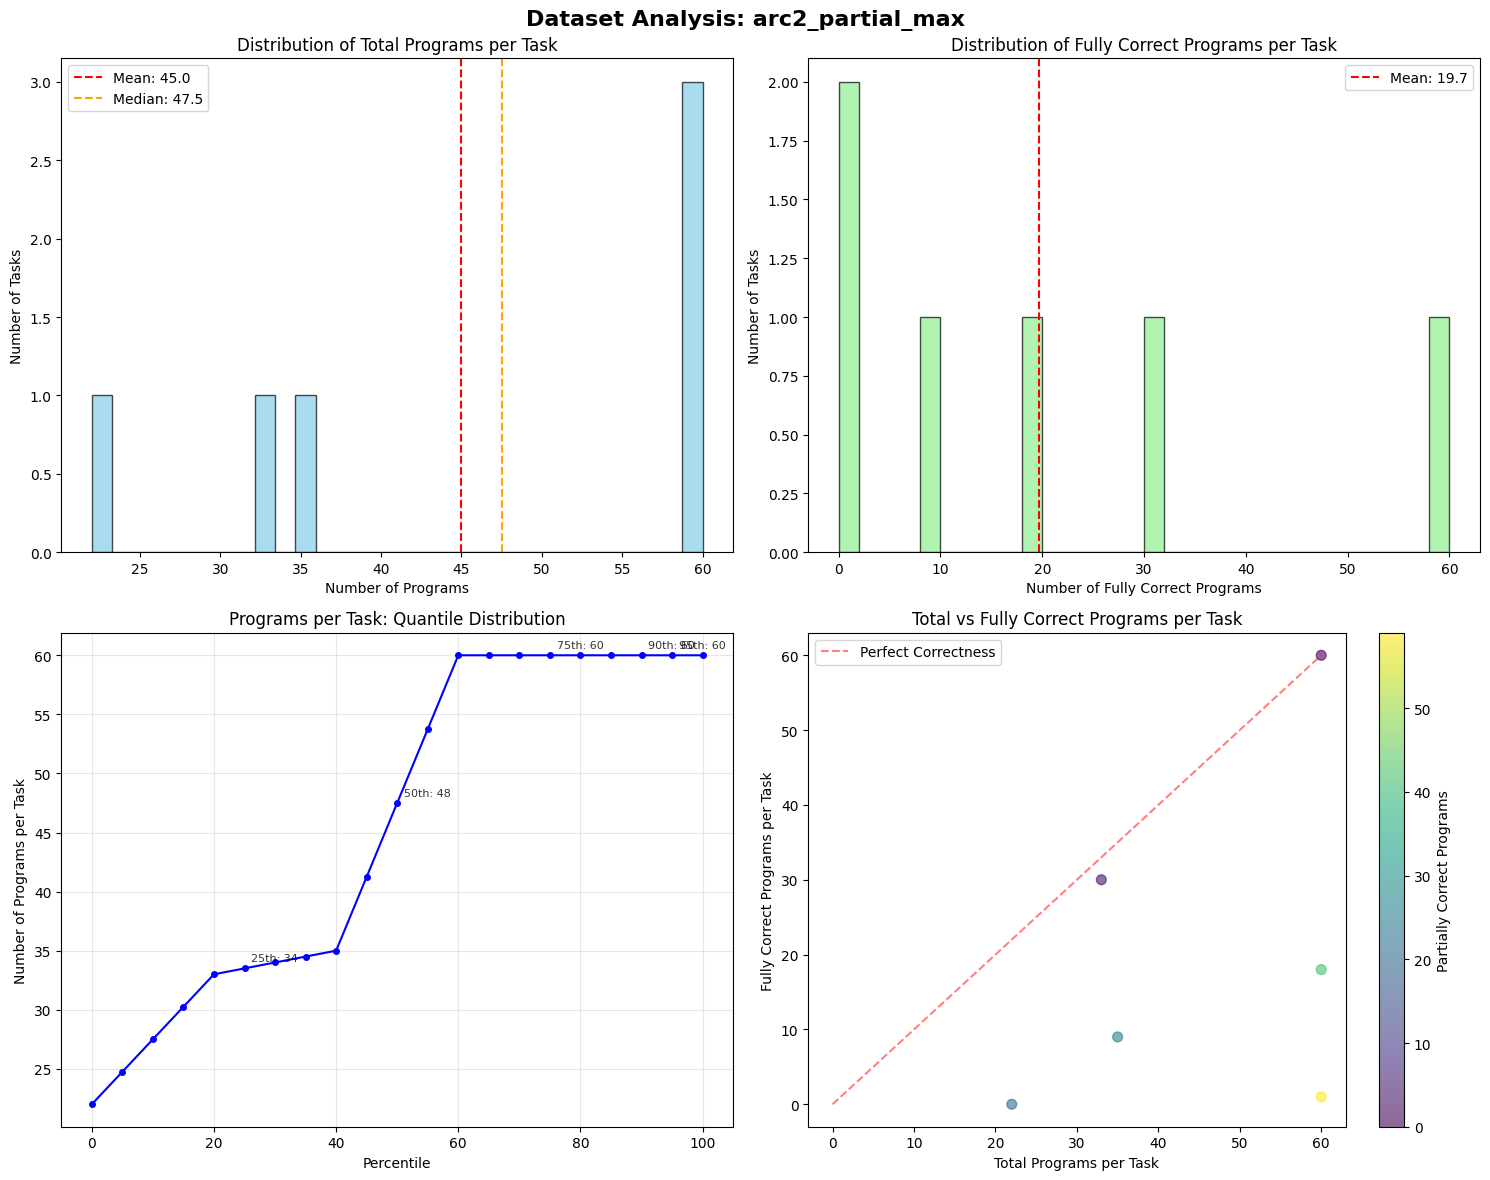


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [ ]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(df, output_path.parts[-1].replace(".parquet", ""))